In [80]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nussl
from utils import viz, data
import yaml
import os

In [81]:
import json
from nussl.datasets import transforms as nussl_tfm
from pathlib import Path

In [82]:
from models.MaskInference import MaskInference
from models.UNet import UNetSpect
from models.Filterbank import Filterbank
from models.Waveform import Waveform

nussl.ml.register_module(MaskInference)
nussl.ml.register_module(UNetSpect)
nussl.ml.register_module(Filterbank)
nussl.ml.register_module(Waveform)

In [83]:
# model_name = 'filterbank_1source'
# model_name = 'waveform_1source'
# model_name = 'unet_1source'
# model_name = 'mask_1source'

# model_name = 'filterbank_4source'
# model_name = 'waveform_4source'
# model_name = 'unet_1source'
model_name = 'mask_4source'

In [84]:
model_path = 'models/'+model_name+'/checkpoints/latest.model.pth'
config_path = 'models/'+model_name+'/configs.yml'
#Optimizer checkpoints no longer stored
#optimizer_path = 'models/'+model_name+'/checkpoints/latest.optimizer.pth'

In [85]:
#Load yaml configs into configs dictionary
with open(config_path,'r') as f:
    configs = yaml.safe_load(f)
    f.close()

model_type = configs['model_type']
waveform_models = ['Filterbank','Waveform','WaveUNet']
if model_type in waveform_models:
    stft_params = None
    
    if configs['model_params']['num_sources']==1:
        tfm = nussl_tfm.Compose([
            nussl_tfm.SumSources([['bass', 'drums', 'other']]),
            nussl_tfm.GetAudio(),
            nussl_tfm.IndexSources('source_audio', 1),
            nussl_tfm.ToSeparationModel(),
        ])
    elif configs['model_params']['num_sources']==2:
        tfm = nussl_tfm.Compose([
            nussl_tfm.SumSources([['bass', 'drums', 'other']]),
            nussl_tfm.GetAudio(),
            nussl_tfm.ToSeparationModel(),
        ])
    elif configs['model_params']['num_sources']==4:
        tfm = nussl_tfm.Compose([
            nussl_tfm.GetAudio(),
            nussl_tfm.ToSeparationModel(),
        ])
    else:
        raise ValueError('Number of sources can only be 1 (vocals), 2 (vocals/accompaniement), or 4 (full sep)')
    
    target_key = 'source_audio'
    output_key = 'audio'
    input_key = 'mix_audio'
    
    separator = nussl.separation.deep.DeepAudioEstimation(
        nussl.AudioSignal(), model_path=model_path,
        device='cpu',
    )
    
else:
    stft_params = nussl.STFTParams(**configs['stft_params'])
    
    if configs['model_params']['num_sources']==1:
        tfm = nussl_tfm.Compose([
            nussl_tfm.SumSources([['bass', 'drums', 'other']]),
            nussl_tfm.MagnitudeSpectrumApproximation(),
            nussl_tfm.IndexSources('source_magnitudes', 1),
            nussl_tfm.ToSeparationModel(),
        ])
    elif configs['model_params']['num_sources']==2:
        tfm = nussl_tfm.Compose([
            nussl_tfm.SumSources([['bass', 'drums', 'other']]),
            nussl_tfm.MagnitudeSpectrumApproximation(),
            nussl_tfm.ToSeparationModel(),
        ])
    elif configs['model_params']['num_sources']==4:
        tfm = nussl_tfm.Compose([
            nussl_tfm.MagnitudeSpectrumApproximation(),
            nussl_tfm.ToSeparationModel(),
        ])
    else:
        raise ValueError('Number of sources can only be 1 (vocals), 2 (vocals/accompaniement), or 4 (full sep)')
    
    target_key = 'source_magnitudes'
    output_key = 'estimates'
    input_key = 'mix_magnitude'
    
    separator = nussl.separation.deep.DeepMaskEstimation(
        nussl.AudioSignal(), model_path=model_path,
        device='cpu',
    )

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


In [86]:
separator.model

SeparationModel(
  (layers): ModuleDict(
    (model): MaskInference(
      (amplitude_to_db): AmplitudeToDB()
      (input_normalization): BatchNorm(
        (batch_norm): BatchNorm1d(257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (recurrent_stack): RecurrentStack(
        (rnn): LSTM(257, 128, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
      )
      (embedding): Embedding(
        (linear): Linear(in_features=256, out_features=1028, bias=True)
      )
    )
    (mask): Alias()
    (estimates): Alias()
  )
)
Number of parameters: 1451526

In [87]:
model_checkpoint = torch.load(model_path,map_location=torch.device('cpu'))
#Optimizer checkpoints no longer stored
#optimizer_checkpoint = torch.load(optimizer_path,map_location=torch.device('cpu'))

In [88]:
model_checkpoint['metadata']['trainer.state_dict']

{'epoch': 25,
 'epoch_length': 25,
 'max_epochs': 25,
 'output': {'L1Loss': 0.0004361253813840449, 'loss': 0.0004361253813840449},
 'metrics': {'avg_loss': 0.00043815523111296863},
 'seed': None}

In [89]:
val_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['validation/loss']
train_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['train/loss']
n_epochs = model_checkpoint['metadata']['trainer.state_dict']['epoch']

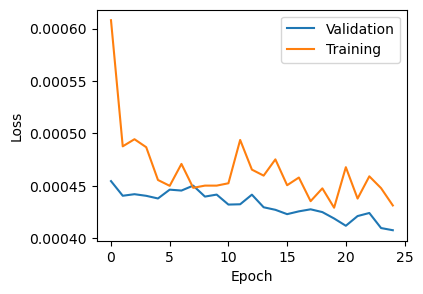

In [93]:
x = np.arange(n_epochs)
plt.figure(figsize=(4,3))
plt.plot(x,val_loss,label='Validation')
plt.plot(x,train_loss,label='Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

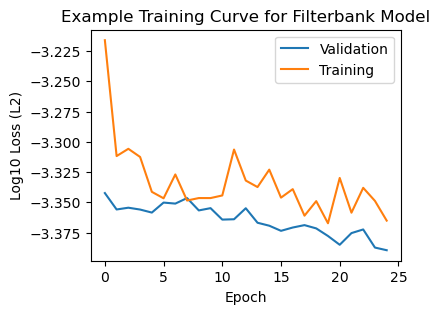

In [94]:
x = np.arange(n_epochs)
plt.figure(figsize=(4,3))
plt.plot(x,np.log10(val_loss),label='Validation')
plt.plot(x,np.log10(train_loss),label='Training')
plt.ylabel('Log10 Loss (L2)')
plt.xlabel('Epoch')
plt.title('Example Training Curve for Filterbank Model')
plt.legend()

In [95]:
from utils import data
#Test on the data
test_folder = configs['test_folder']
test_data = data.mixer(stft_params, transform=tfm, fg_path=configs['test_folder'], num_mixtures=50, coherent_prob=1.0, duration=5)
test_dataloader = torch.utils.data.DataLoader(test_data, num_workers=1, batch_size=1)

In [96]:
for i,batch in enumerate(test_dataloader):
    if i==1:
        batch=batch
        break
    
for key in batch:
    if torch.is_tensor(batch[key]):
        batch[key] = batch[key].float().to('cpu')   

In [97]:
self = separator.model.layers.model
data = batch[input_key]
output = separator.model(batch)

In [21]:
out = output[output_key].detach().numpy()
target = batch[target_key].detach().numpy()

In [22]:
# x = out

# if model_type in waveform_models:
#     num_sources = x.shape[3]
#     fig, axs = plt.subplots(num_sources+1,figsize=(9,3))
#     for i in range(num_sources):
#         axs[i].plot(x.squeeze()[::100,i].T)
# else:
#     num_sources = x.shape[4]
#     fig, axs = plt.subplots(num_sources+1,figsize=(9,3))
#     for i in range(num_sources):
#         axs[i].imshow(np.log((x**2+1e-16).squeeze(0).squeeze(3).T[i]))


In [ ]:
# x = target

# if model_type in waveform_models:
#     num_sources = x.shape[3]
#     fig, axs = plt.subplots(num_sources+1,figsize=(9,3))
#     for i in range(num_sources):
#         axs[i].plot(x.squeeze()[::100,i].T)
# else:
#     num_sources = x.shape[4]
#     fig, axs = plt.subplots(num_sources+1,figsize=(9,3))
#     for i in range(num_sources):
#         axs[i].imshow(np.log((x**2+1e-16).squeeze(0).squeeze(3).T[i]))

In [24]:
np.mean((target-out)**2)

loss_fn = torch.nn.MSELoss()
loss_fn(torch.tensor(target),torch.tensor(out))

loss_fn = torch.nn.L1Loss()
loss_fn(torch.tensor(target),torch.tensor(out))

tensor(0.0007)

In [28]:
from utils import data

#Test on the data
test_folder = configs['test_folder']
test_data = data.mixer(stft_params, transform=None, fg_path=configs['test_folder'], num_mixtures=5, coherent_prob=1.0, duration=5)

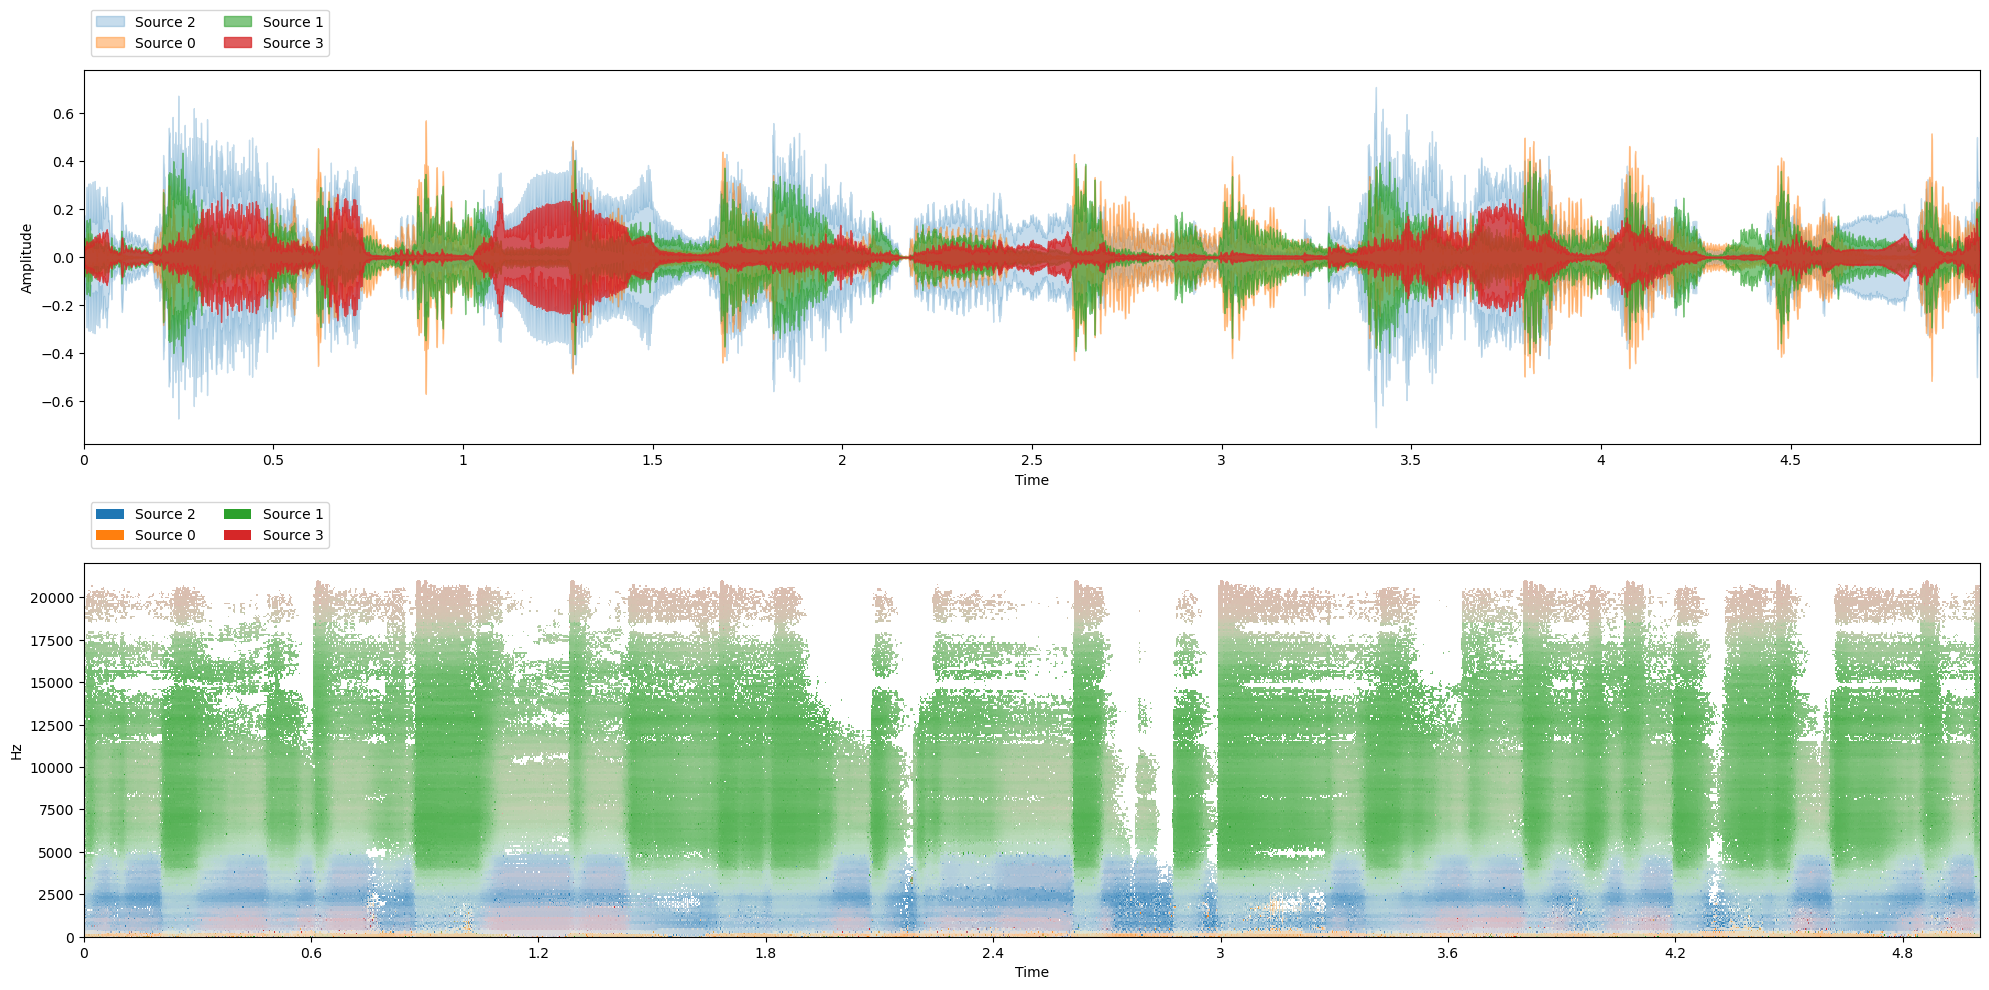


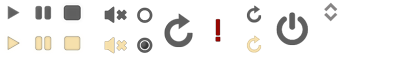
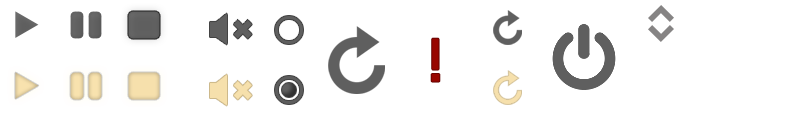
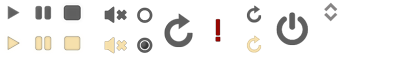

In [31]:
item = test_data[1]
separator.audio_signal = item['mix']
output = separator()
viz.show_sources(output)

In [32]:
item

{'mix': <nussl.core.audio_signal.AudioSignal at 0x7f51a7d40130>,
 'sources': {'vocals': <nussl.core.audio_signal.AudioSignal at 0x7f51ab2fbee0>,
  'drums': <nussl.core.audio_signal.AudioSignal at 0x7f51701e60b0>,
  'bass': <nussl.core.audio_signal.AudioSignal at 0x7f51701e7f40>,
  'other': <nussl.core.audio_signal.AudioSignal at 0x7f51701e7f70>},
 'metadata': {'jam': <JAMS(file_metadata=<FileMetadata(...)>,
        annotations=[1 annotation],
        sandbox=<Sandbox(...)>)>,
  'idx': 1}}

In [33]:
output

In [36]:
order = ['bass','drums','other','vocals']

In [64]:
source_keys = list(item['sources'].keys())

order = ['bass','drums','other','vocals']

estimates = []
sources = []
for i,source in enumerate(order[0:len(source_keys)+1]):
    estimates.append(output[i])
    sources.append(item['sources'][source])

In [78]:
[k for k,v in item['sources'].items()]

['vocals', 'drums', 'bass', 'other']

In [79]:
output